# **Car Market Analysis**
By Paweł Grzeszczyk

**Project overview**:  
Project's main goal is to run complex analysis to investigate key factors influencing the car prices.

The analysis document is split into several parts that include:

- **Data aquisition** (building web scraping programme to gather real data)
- **Exploratory data analysis** (performing a basic analysis of the data as well as looking for its structure and patterns)
- **Data Cleaning** (fixing the data types and deling with missing values in order to prepare data for further analysis)
- **Market overview** (discovering the distribution of car prices and calculating the basic statistics of the data)
- **Analysis** (asking questions and providing answers based on the data)
- **Regression model** (evaluating how each feature impacts the price)

## **Importing modules**
In the very first step of the process I'm importing the necessary modules for analysis and data aqusition.

In [33]:
# webscrapper
from links_scraper import links_scraper
from data_scraper import data_scraper

# data analysis
import numpy as np
import pandas as pd

# data vizualization
import seaborn as sns
import matplotlib.pyplot as plt

# predefined variable
import const

## **Data aquisition**
I have designed dedicated web scraper programme to collect car data directly from otomoto.pl website.  
Programme allows users to pick a brand that he's interested in and looks for offers based on this criteria.  
Individual offer data is saved as record in CSV file.

**Important Note**: Please do not run this cell unless you want to download the data.  

In [34]:
# choosing a car brand 
const.brand = 'skoda'
print('Selected {} as a desierd brand.'.format(const.brand))

links_scraper()
data_scraper()

Selected skoda as a desierd brand.


## **Importing data**
In this step I'm converting CSV file into pandas dataframe.

In [35]:
data = pd.read_csv('datasets/data_{}.csv'.format(const.brand))
print('Imported data contains of {} observations.'.format(len(data)))

Imported data contains of 6179 observations.


## **Exploratory data analysis**
The main goal of EDA phase is to learn the structre of the data. Furthermore, this is also a great  
opportunity to discover any inconsistencies or missing valus across the dataset.

At the beginning, I will investigate the last five rows of `data` dataset.

In [36]:
data.tail(5)

,brand,model,production_year,mileage[KM],fuel_type,power[HP],gearbox,door_no,seat_no,color,origin_country,status,price[PLN]
6174,Škoda,Fabia,2018.0,109 795 km,Benzyna,110 KM,Manualna,5.0,5.0,Biały,Polska,Używane,47 900 PLN\n
6175,Škoda,Superb,2017.0,118 878 km,Diesel,120 KM,Manualna,5.0,5.0,Inny kolor,NaN,Używane,73 000 PLN\n
6176,Škoda,Karoq,2019.0,57 418 km,Diesel,115 KM,Automatyczna,5.0,5.0,Szary,Polska,Używane,105 900 PLN\n
6177,Škoda,Superb,2017.0,152 000 km,Diesel,190 KM,Automatyczna,5.0,5.0,Inny kolor,Niemcy,Używane,110 000 PLN\n
6178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see above, data is likely to have a few limitations. We can already notice that there are a few  
formatting issues (e.g. currency is the part of the value). Moreover there are some missing values in many columns  
as well as there is at least one completly empty observation.

To ensure the data is consistent I'm going to check the data dypes and missing values for each relevant column.

### **Checking column data types**  

In [37]:
data.dtypes

brand               object
model               object
production_year    float64
mileage[KM]         object
fuel_type           object
power[HP]           object
gearbox             object
door_no            float64
seat_no            float64
color               object
origin_country      object
status              object
price[PLN]          object
dtype: object

Colums that are supposed to have numerical values (`mileage[KM]`, `power[HP]`, `price[PLN]`) are not formated as floats or strings.  

**Defining data cleaning functions**

In [38]:
# Removing units from numerical values formated as strings
def unit_del(val):
    try:
        val = str(val) 
        val = val.split() 
        val.pop() 
        val = ''.join(val) 
        val = int(val)
    except:
        val = np.NaN
    return val

# Conversion to int
def conversion_int(arr):
    new_arr = []
    for i in arr:
        try:
            i = int(i)      
            new_arr.append(i)
        except:
            new_arr.append(np.NaN)
    return new_arr

# Conversion to float
def conversion_float(arr):
    new_arr = []
    for i in arr:
        try:
            i = float(i)      
            new_arr.append(i)
        except:
            new_arr.append(np.NaN)
    return new_arr

**Updating dataframe**

In [39]:
# Datatype conversion
data['mileage[KM]'] = [unit_del(i) for i in data['mileage[KM]']]
data['mileage[KM]'] = conversion_int(data['mileage[KM]'])

data['power[HP]'] = [unit_del(i) for i in data['power[HP]']]
data['power[HP]'] = conversion_int(data['power[HP]'])

data['price[PLN]'] = [unit_del(i) for i in data['price[PLN]']]
data['price[PLN]'] = conversion_float(data['price[PLN]'])

### **Looking for missing values**

In [40]:
data.isna().sum()

brand                 9
model                 9
production_year       9
mileage[KM]          47
fuel_type             9
power[HP]            10
gearbox               9
door_no              23
seat_no             209
color                 9
origin_country     1563
status                9
price[PLN]           15
dtype: int64

As expected, there are multiple missing value in the dataset.

In [41]:
# I drop rows where value in brand column is missing
data.drop(data[data['brand'].isna()].index, axis=0, inplace=True)

# missing value in power[HP] I fill in by hand, taking the mean value of the offers of cars with similar parameters
missing_power = data[data['power[HP]'].isna()]

similar_offers = data[(data['model'] == missing_power['model'].values[0]) & 
    (data['production_year'] == missing_power['production_year'].values[0]) & 
    (data['fuel_type'] == missing_power['fuel_type'].values[0]) & 
    (data['gearbox'] == missing_power['gearbox'].values[0])]

data.loc[data['power[HP]'].isna(), 'power[HP]'] = similar_offers['power[HP]'].mean()

# I drop observations with missing price data since they are no use to the analysis
data.drop(data[data['price[PLN]'].isna()].index, axis=0, inplace=True)

# I replace multiple missing values in column 'origin_country' with 'not_specified' string
data.loc[data['origin_country'].isna(), 'origin_country'] = 'not_specified'

# Once more I fix the date format, because during dealing with missing values it formated to float
data['production_year'] = conversion_int(data['production_year'])

### **Cleaning tests**  

In [42]:
print('Formated datatypes:')
print(data[['production_year', 'mileage[KM]', 'power[HP]', 'price[PLN]']].dtypes)
print('\nMissing values summary:')
data.isna().sum()

Formated datatypes:
production_year      int64
mileage[KM]        float64
power[HP]          float64
price[PLN]         float64
dtype: object

Missing values summary:


brand                0
model                0
production_year      0
mileage[KM]         38
fuel_type            0
power[HP]            0
gearbox              0
door_no             14
seat_no            200
color                0
origin_country       0
status               0
price[PLN]           0
dtype: int64

I do not perform any changes on on `mileage[KM]`, `door_no` and `seat_no` since they contain numerical data  
that is strictly tied to the specific offer. Trying to replace it or change would be pointless and only would  
cause unnecessary mess during the analysis process.

Now, all columns selected for modification are saved in appropriate format.  
Thanks to this change, it is possible to carry matematical opperations and perform analysis on these columns.

## **Analysis**

The ultimate goal of the analysis is to investigate how different factors affect the prices of cars.

### **Market overview**  
At the begining, its important to check the general metrics. 

In [43]:
summary = f"""General statistics:
- Total number of cars: {len(data)}  
- Avearge price: {round(data['price[PLN]'].mean(), 2)}  
- Median price: {round(data['price[PLN]'].median(), 2)} 
"""
print(summary)

General statistics:
- Total number of cars: 6164  
- Avearge price: 63228.45  
- Median price: 49999.0 



We can see above that there is quite substential difference between average and median price values.  
Mean value is larger then the median, having that in mind we can already suspect that the price distribution is right skewd.

**Price distribution**  
To illustrate this let's have a look at the **histogram**. 

[Text(0.5, 1.0, 'Price distribution histogram')]

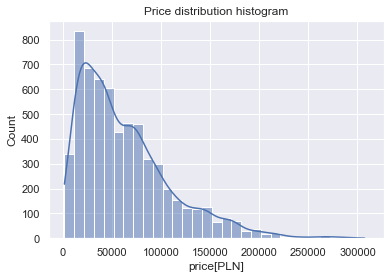

In [44]:
sns.set_theme(style="darkgrid")
sns.histplot(data = data,
    x='price[PLN]',
    binwidth=10000,
    kde=True).set(title='Price distribution histogram')

Creating a **boxplot** may help to analyze price distribution even further.

min      1500.0
25%     26900.0
50%     49999.0
75%     86900.0
max    307251.0
Name: price[PLN], dtype: float64

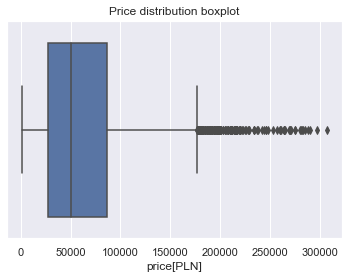

In [45]:
sns.set_theme(style="darkgrid")
sns.boxplot(x=data['price[PLN]']).set(title='Price distribution boxplot')

data['price[PLN]'].describe()[['min', '25%', '50%', '75%', 'max']]

We can deffinitely confirm our initial assumpition about the distribution.  
The majority of offers listed fall between 30,000 and 80,000 price range.  
The assymetry is likely to be caused by a few (compared to the whole dataset) observations of very expensive cars.

### **Which models are the most expensive?**

**Important note**: I filter out the models that accur less than 100 times in a dataset since they won't be statistically significant.

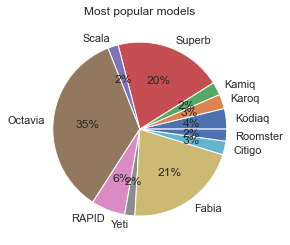

,mean
model,
Kodiaq,151330.90
Karoq,129789.38
Kamiq,102035.01
Superb,93645.58
Scala,86061.58
Octavia,54065.36
RAPID,39508.06
Yeti,38042.34
Fabia,32502.77


In [46]:
model_data = data.groupby('model')['price[PLN]'].agg([len, np.mean]).sort_values('mean', ascending=False)
model_data = model_data[model_data['len'] > 100]
model_data['mean'] = round(model_data['mean'], 2)

plt.pie(model_data['len'], labels=model_data.index, autopct='%.0f%%')
plt.rcParams["figure.figsize"] = (8,10)
plt.title('Most popular models')
plt.show()

pd.DataFrame(model_data['mean'])

A pie chart above is presenting the most popular models in the dataset.

Analysing the table we can tell that on average the most expensive models are:
- Kodiaq (avg. price close to 150,000pln)
- Karoq
- Kamiq  

On average the least expensive model is Roomster, which price is almost 20,000pln.

Octavia, which is the most popular model has an average price close to the average price of the whole dataset.

### **Does the year of production affect price?**

**Important note**: I filter out the models that were produced before year 2000 in order to increase the readability of the chart.

Correlation = 0.72


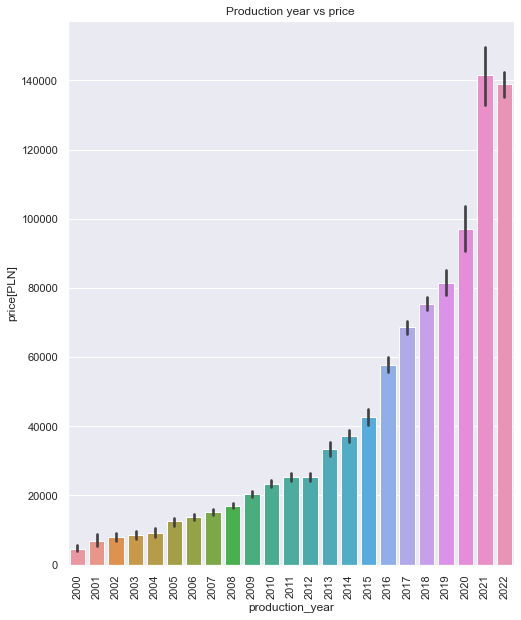

In [47]:
year_data = data[data['production_year']>=2000]

sns.set_theme(style="darkgrid")
plt.xticks(rotation=90)
sns.barplot(data = year_data,
    x='production_year',
    y = 'price[PLN]').set(title='Production year vs price')

corr_year_price = round(year_data['production_year'].corr(year_data['price[PLN]'], method='pearson'), 2)
print('Correlation = {}'.format(corr_year_price))

Based on the bar plot above it can be said without any doubt that production year  
has significant influence on price. It's also confirmed by the value of pearson  
correlation equal to 0.72, which means strong positive correlation between the variables.

**Conclusion**: As the year of producion increase so does the price.

### **Are cars with higher mileage cheaper?**

Correlation = -0.63


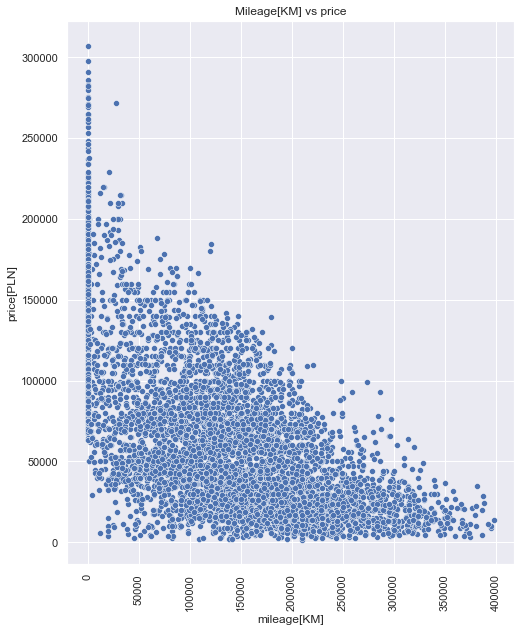

In [48]:
year_data = data[data['mileage[KM]']<400000]

sns.set_theme(style="darkgrid")
plt.xticks(rotation=90)
sns.scatterplot(data = year_data,
    x='mileage[KM]',
    y = 'price[PLN]').set(title='Mileage[KM] vs price')

corr_year_price = round(year_data['mileage[KM]'].corr(year_data['price[PLN]'], method='pearson'), 2)
print('Correlation = {}'.format(corr_year_price))

Once more I can draw conclusions based only on the graph: mileage has significant influence on price.  
It's also confirmed by the value of pearson correlation equal to -0.63, which means strong negative correlation between the variables.

**Conclusion**: As the mileage is increasing the price is decreasing. Cars with lower mileage tend to be cheaper.

### **Manual or automatic? Diesel or gasoline?**

len       mean
gearbox      fuel_type                 
Automatyczna Benzyna     758  110443.95
             Diesel     1076   98782.66
Manualna     Benzyna    2337   44374.26
             Diesel     1598   46142.85

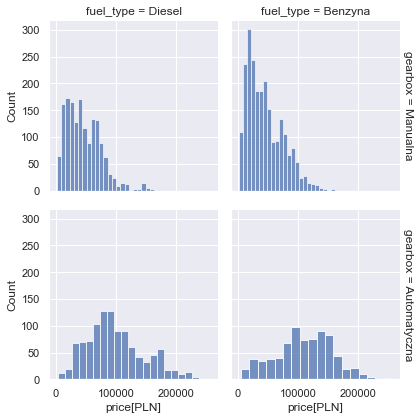

In [49]:
data_type = data.groupby(['gearbox', 'fuel_type'])['price[PLN]'].agg([len, np.mean])
data_type = data_type[data_type['len']>500]
data_type['mean'] = round(data_type['mean'], 2)

data_grid = data[data['fuel_type'].isin([x[1] for x in data_type.index])]
grid = sns.FacetGrid(data_grid, row='gearbox', col='fuel_type', margin_titles=True)
grid.map(sns.histplot, 'price[PLN]')

pd.DataFrame(data_type)

In the first place it has to be mentioned that there is much less observations of cars with automatic gearbox.  
Based on the table and the charts above it can be summarised that cars with manual gearbox seem to be way cheeper.  
The price disdribution is right skewed.  
What's interesting distriburion for for automatic gearboxes looks as it was tending to normal distribution.  
Fuel type seems to not to influence the price on the high level.

### **Are new cars more expensive than the used ones?**

,price[PLN]
status,
Nowe,141377.92
Używane,53920.89


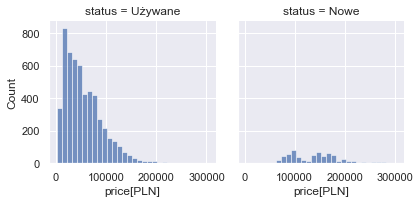

In [50]:
grid = sns.FacetGrid(data[data['price[PLN]'] < 300000].reset_index(), col='status')
grid.map(sns.histplot, 'price[PLN]', binwidth = 10000)

pd.DataFrame(round(data.groupby('status')['price[PLN]'].mean(), 2))

As expected, new cars are far more expensive than the used ones, so the distribution "moves to the right".  
Mean price of the new cars is also far greater.